Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 100)]             0         
                                                                 
 sequential (Sequential)     (None, 28, 28, 1)         856193    
                                                                 
 sequential_1 (Sequential)   (None, 1)                 212865    
                                                                 
Total params: 1,069,058
Trainable params: 855,809
Non-trainable params: 213,249
_________________________________________________________________
1/1 [==============================] - 0s 422ms/step
epoch:0 d_loss:0.7321 g_loss0.4844
1/1 [==============================] - 0s 262ms/step


FileNotFoundError: [Errno 2] No such file or directory: 'gan_images/gan_mnist_0.png'

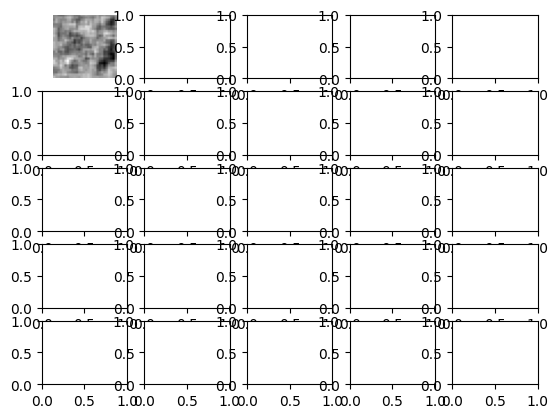

In [1]:
from tensorflow.keras.datasets import mnist
from tensorflow.keras.layers import  Dense, Reshape, Dropout, Flatten,Input
from tensorflow.keras.layers import BatchNormalization, Activation, LeakyReLU, UpSampling2D, Conv2D
from tensorflow.keras.models import Sequential, Model
import numpy as np
import matplotlib.pyplot as plt

generator = Sequential() 
generator.add(Dense(128 * 7 * 7, input_dim=100))
generator.add(Activation(LeakyReLU(0.2)))
generator.add(Reshape((7,7,128))) 
generator.add(UpSampling2D()) 
generator.add(Conv2D(128, kernel_size=3, padding='same'))  
generator.add(BatchNormalization())  
generator.add(Activation(LeakyReLU(0.2))) 
generator.add(UpSampling2D())  
generator.add(Conv2D(64, kernel_size=3, padding='same')) 
generator.add(BatchNormalization()) 
generator.add(Activation(LeakyReLU(0.2)))  
generator.add(Conv2D(1, kernel_size=3, padding='same', activation='tanh'))

discriminator = Sequential()
discriminator.add(Conv2D(64, kernel_size=5, strides=2, input_shape=(28,28,1), padding='same'))
discriminator.add(Activation(LeakyReLU(0.2)))  
discriminator.add(Dropout(0.3))
discriminator.add(Conv2D(128, kernel_size=5, strides=2, padding='same'))
discriminator.add(Activation(LeakyReLU(0.2)))
discriminator.add(Dropout(0.3))
discriminator.add(Flatten())
discriminator.add(Dense(1, activation='sigmoid'))
discriminator.compile(loss='binary_crossentropy', optimizer='adam')
discriminator.trainable=False

ginput = Input(shape=(100,))
dis_output = discriminator(generator(ginput))
gan = Model(ginput, dis_output)
gan.compile(loss = 'binary_crossentropy', optimizer = 'adam')
gan.summary()

# 신경망 실행시키는 함수
def gan_train(epoch, batch_size, saving_interval) :

  #MNIST
  (X_train,_), (_, _) = mnist.load_data()
  X_train = X_train.reshape(X_train.shape[0], 28, 28, 1).astype('float32')
  X_train = (X_train - 127.5)/127.5

  true = np.ones((batch_size,1))
  fake = np.zeros((batch_size, 1))

  for i in range(epoch) :
    # 실제 데이터를 판별자에 입력
    idx = np.random.randint(0, X_train.shape[0], batch_size)
    imgs = X_train[idx]
    d_loss_real = discriminator.train_on_batch(imgs, true)

    # 가상 이미지를 판별자에 입력
    noise = np.random.normal(0, 1, (batch_size, 100))
    gen_imgs = generator.predict(noise)
    d_loss_fake = discriminator.train_on_batch(gen_imgs, fake)

    # 판별자와 생성자의 오차를 계산
    d_loss = 0.5 * np.add(d_loss_real, d_loss_fake)
    g_loss = gan.train_on_batch(noise,true)

    print('epoch:%d' % i, 'd_loss:%.4f'% d_loss, 'g_loss%.4f'%g_loss)

    if i % saving_interval ==0:
      # r,c = 5, 5
      noise = np.random.normal(0,1,(25,100))
      gen_imgs = generator.predict(noise)
      # rescale images 0-1
      gen_imgs = 0.5 * gen_imgs + 0.5

      fig, axs = plt.subplots(5,5)
      count = 0
      for j in range(5):
        for k in range(5):
          axs[j,k].imshow(gen_imgs[count, :, :, 0], cmap='gray')
          axs[j,k].axis('off')
          count +=1
          fig.savefig('gan_images/gan_mnist_%d.png'%i)

gan_train(4001,32,200)